In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/vegetables.zip' -d 'drive/MyDrive/'

Archive:  drive/MyDrive/vegetables.zip
   creating: drive/MyDrive/vegetables/
   creating: drive/MyDrive/vegetables/apple gourd/
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent1.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent18.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent28.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent3.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent48.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent49.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd transparent5.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd1.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd10.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd11.jpg  
  inflating: drive/MyDrive/vegetables/apple gourd/apple gourd12.jpg  
  inflating: drive/My

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential,Model
import tensorflow as tf
import tensorflow_hub as hub 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for TPU
print("TPU", "available (YESS!!!!)" if tf.config.list_physical_devices("TPU") else "not available :(")

TF version: 2.4.1
Hub version: 0.12.0
TPU not available :(


In [ ]:
import splitfolders

In [ ]:
input = 'drive/MyDrive/vegetables'
output = 'drive/MyDrive/vegetables_dataset'
splitfolders.ratio(input,output,seed = 224, ratio = (0.8,0.2))

Copying files: 3320 files [00:35, 94.20 files/s] 


In [ ]:
img_width, img_height = (224,224)
batch_size = 32
train_data_directory = "drive/MyDrive/vegetables_dataset/train"
val_data_directory = "drive/MyDrive/vegetables_dataset/val"

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,fill_mode="nearest")
train_generator = datagen.flow_from_directory(train_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)
val_generator = datagen.flow_from_directory(val_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)

Found 2643 images belonging to 39 classes.
Found 677 images belonging to 39 classes.


In [ ]:
INPUT_SHAPE = [None, img_height, img_width, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = train_generator.num_classes

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4"

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 1001)              4254889   
_________________________________________________________________
dense_11 (Dense)             (None, 39)                39078     
Total params: 4,293,967
Trainable params: 39,078
Non-trainable params: 4,254,889
_________________________________________________________________


In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime
import os
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2)

In [ ]:
NUM_EPOCHS = 10 #@param {type:"slider", min:5, max:100, step:5}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_generator,
            epochs=NUM_EPOCHS,
            validation_data=val_generator,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
#Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4
Epoch 1/10
83/83 [==============================] - 153s 2s/step - loss: 5.0180 - accuracy: 0.2129 - val_loss: 1.6950 - val_accuracy: 0.5480
Epoch 2/10
83/83 [==============================] - 150s 2s/step - loss: 1.2284 - accuracy: 0.6795 - val_loss: 1.2584 - val_accuracy: 0.6750
Epoch 3/10
83/83 [==============================] - 149s 2s/step - loss: 0.8165 - accuracy: 0.7570 - val_loss: 1.2255 - val_accuracy: 0.6839
Epoch 4/10
83/83 [==============================] - 149s 2s/step - loss: 0.6025 - accuracy: 0.8199 - val_loss: 1.1157 - val_accuracy: 0.7149
Epoch 5/10
83/83 [==============================] - 149s 2s/step - loss: 0.4677 - accuracy: 0.8612 - val_loss: 1.0882 - val_accuracy: 0.7267
Epoch 6/10
83/83 [==============================] - 150s 2s/step - loss: 0.4060 - accuracy: 0.8770 - val_loss: 1.0909 - val_accuracy: 0.7341
Epoch 7/10
83/83 [==============================] - 149s 2s/s

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
test_data_directory = "drive/MyDrive/vegetables_datasets/test"

In [ ]:
test_generator = datagen.flow_from_directory(test_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=1)

Found 693 images belonging to 39 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator,verbose=1)

693/693 [==============================] - 42s 61ms/step - loss: 1.0065 - accuracy: 0.7345


In [ ]:
# Save our model trained on whole images
save_model(model, suffix="images-mobile-net-v1.h5")

Saving model to: drive/MyDrive/Data/models/20210420-19161618946190-images-mobile-net-v1.h5.h5...


'drive/MyDrive/Data/models/20210420-19161618946190-images-mobile-net-v1.h5.h5'

corinander


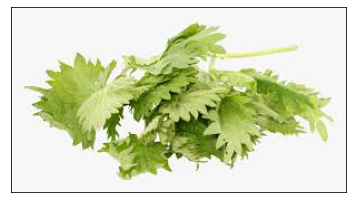

In [ ]:
import os
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path = '/content/drive/MyDrive/vegetables_datasets/val/corinander/corinander transparent62.jpg'
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat
    # load a single image
    new_image = load_image(img_path)
    import matplotlib.image as mpimg
    plt.imshow(mpimg.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    # check prediction
    pred = model.predict(new_image)
    unique_class = test_generator.class_indices
    newlist = []
    for i in unique_class.keys():
      newlist.append(i)
    print(newlist[pred.argmax()])